# Test RNN Policy  with Engine Failure

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Mars3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_Meta-Learning-master/Experiments/Mars3DOF/Engine_failure


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
queue fixed
Flat Constraint


<IPython.core.display.Javascript object>


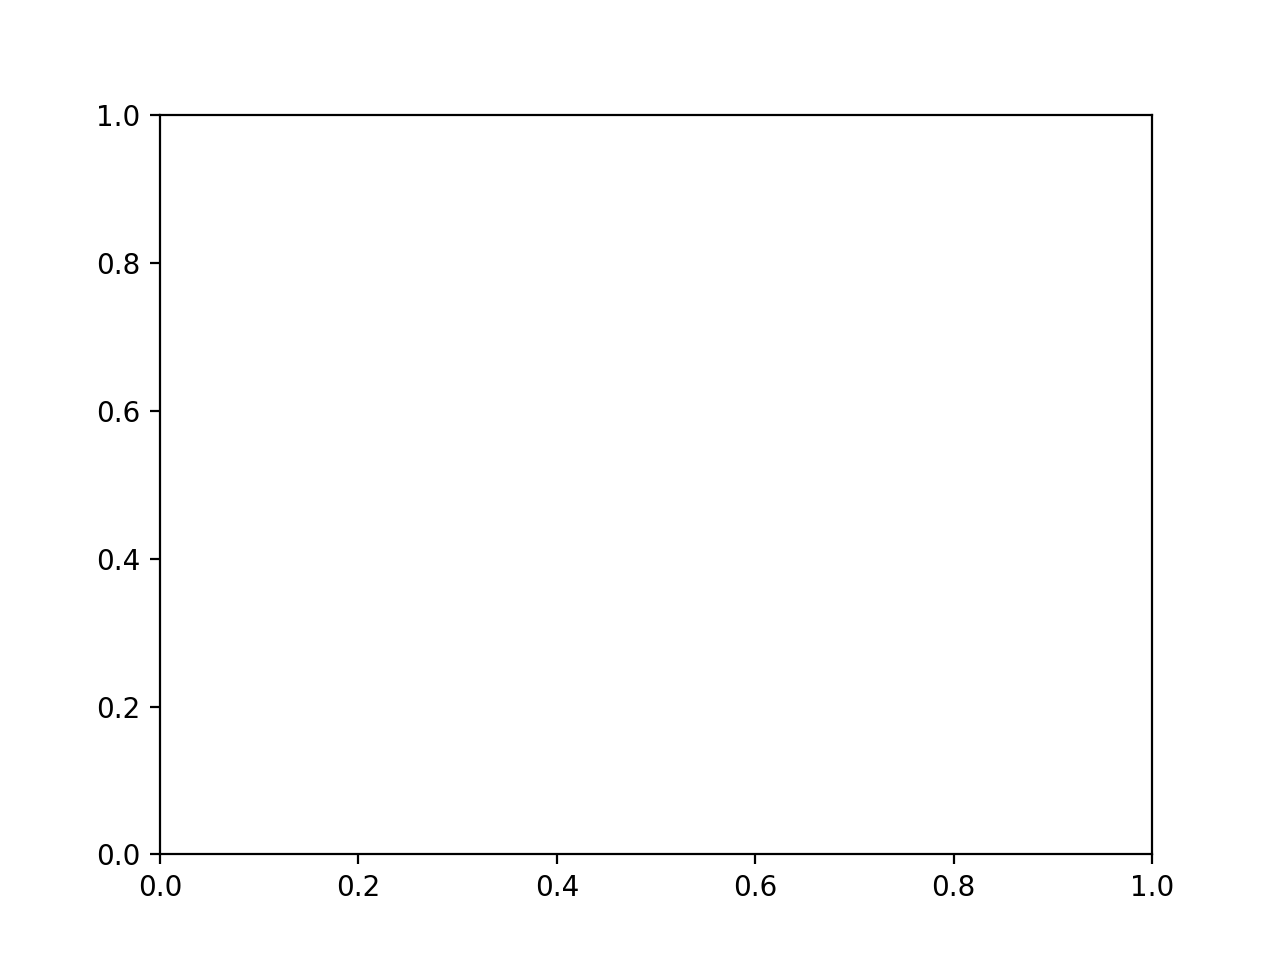

<IPython.core.display.Javascript object>


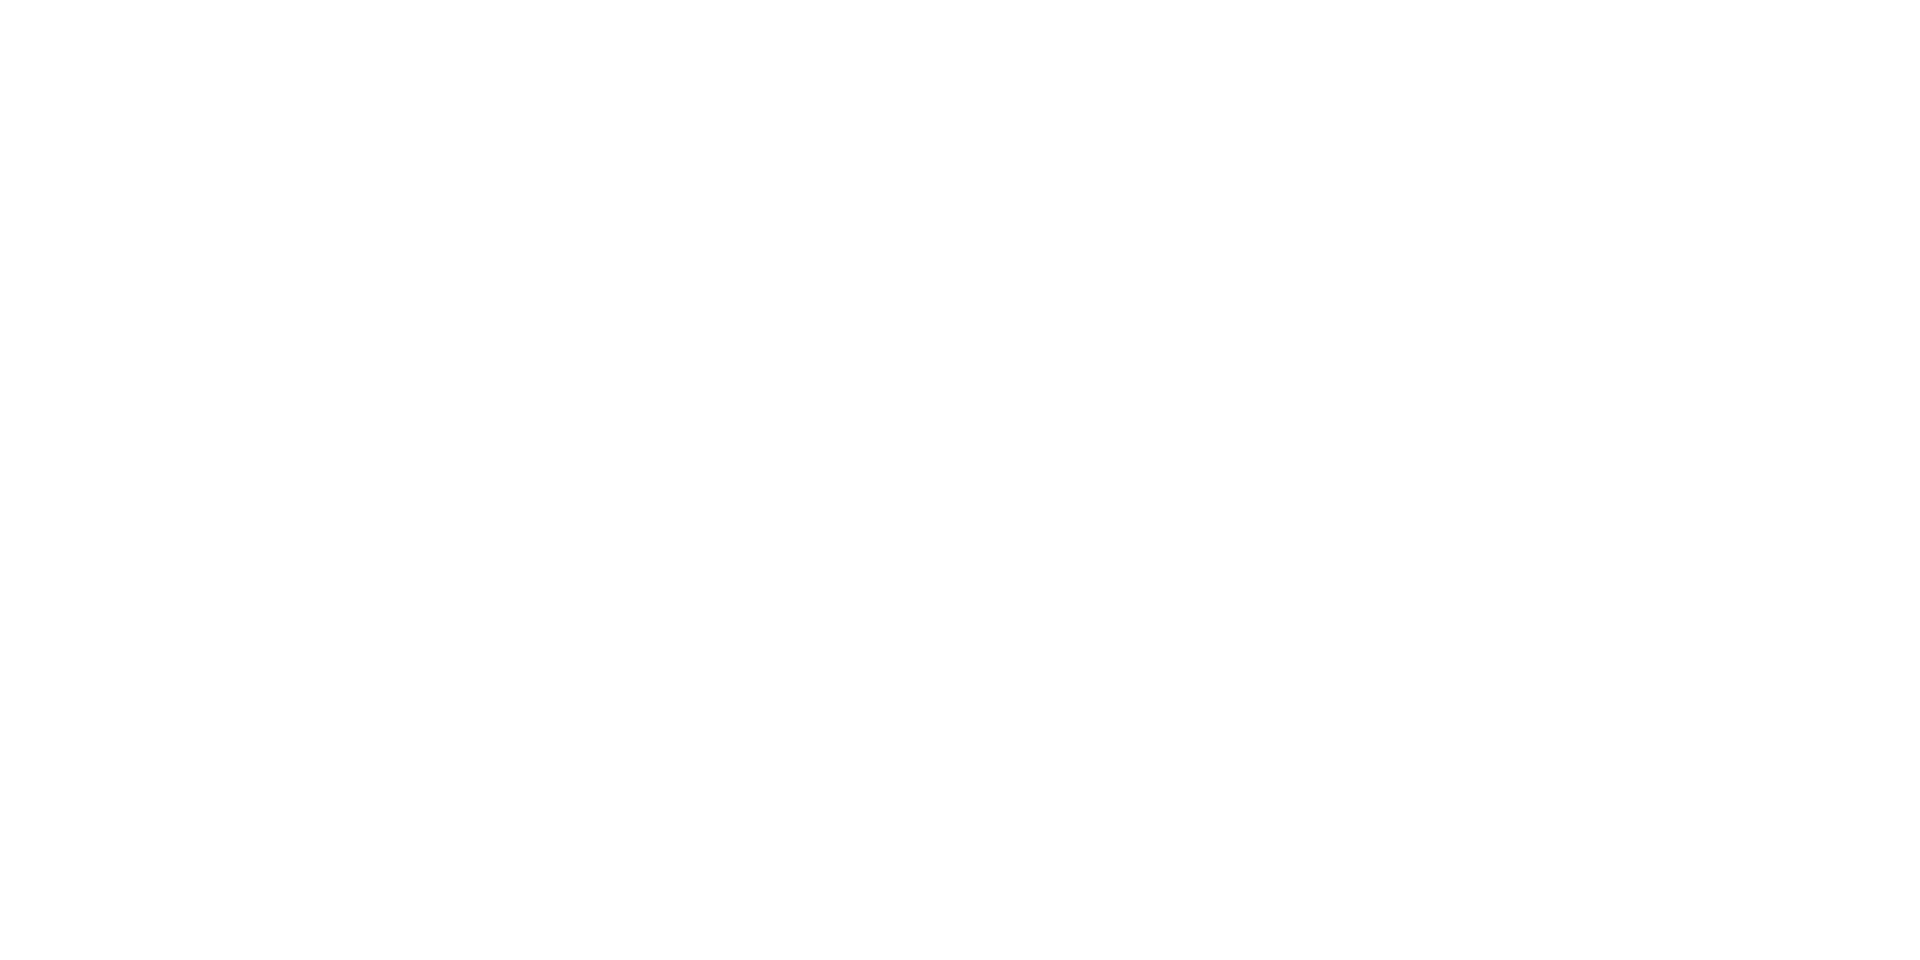

<IPython.core.display.Javascript object>


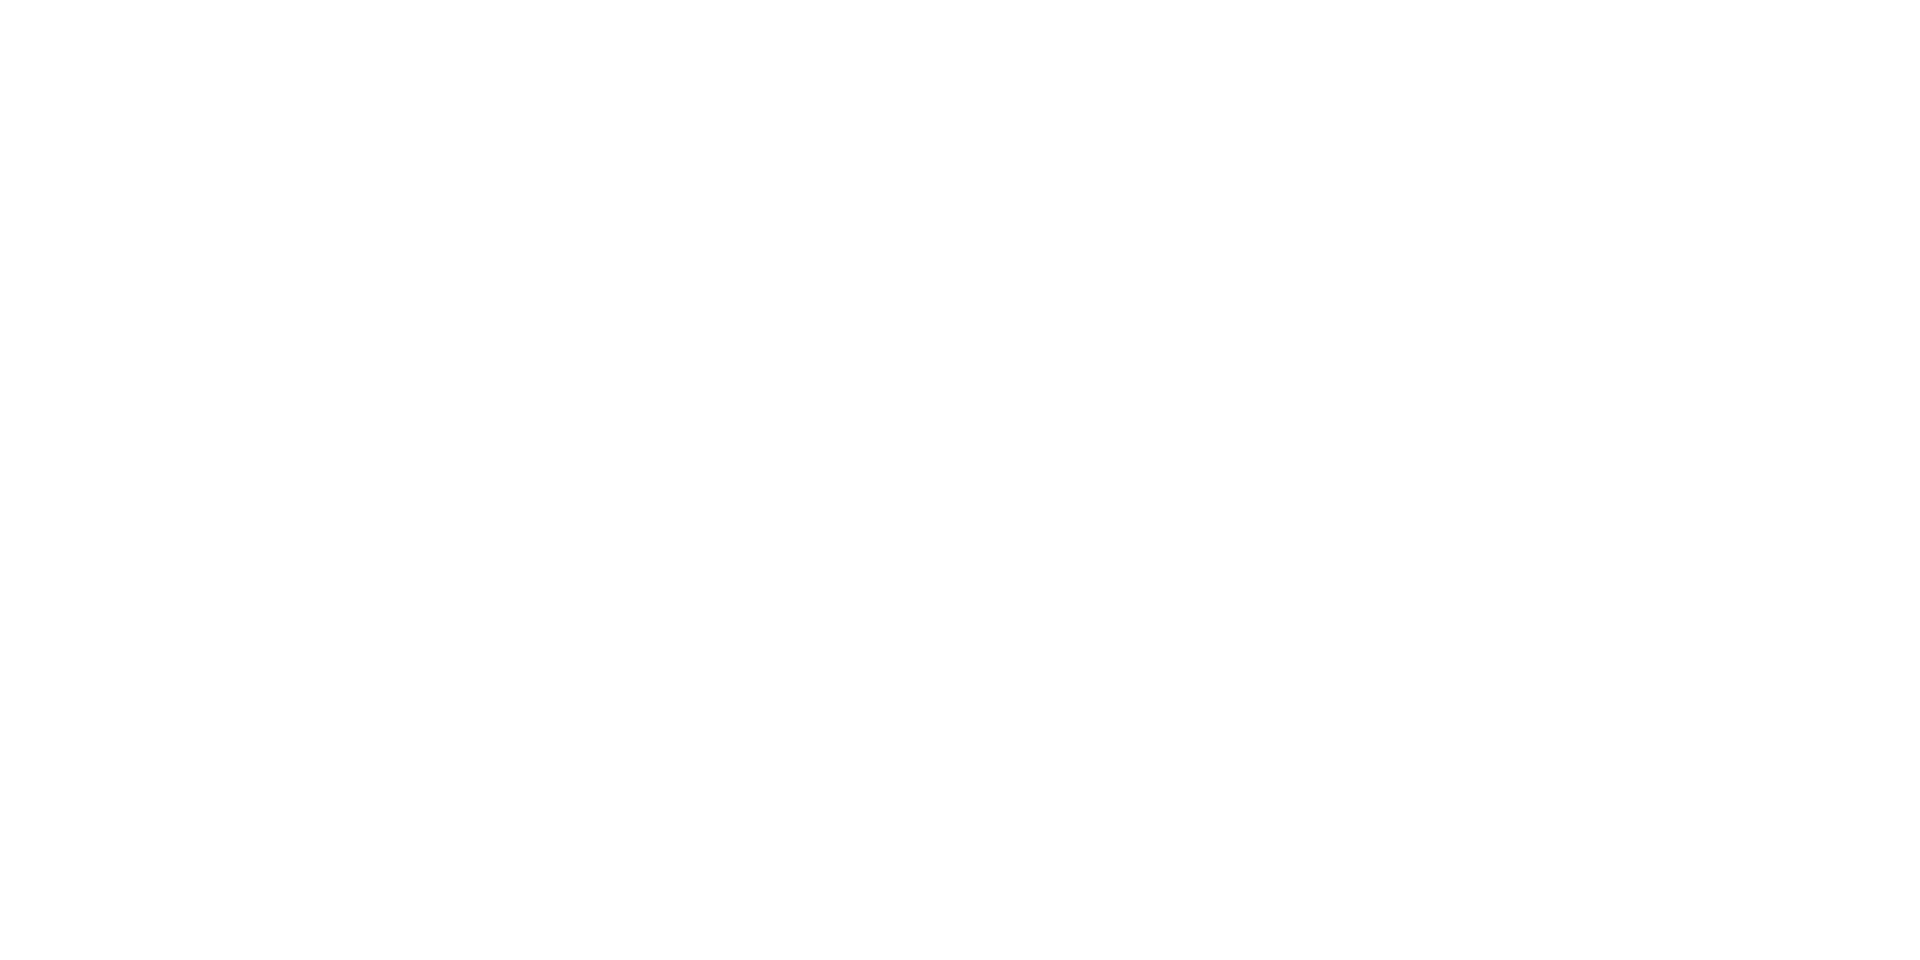

<IPython.core.display.Javascript object>


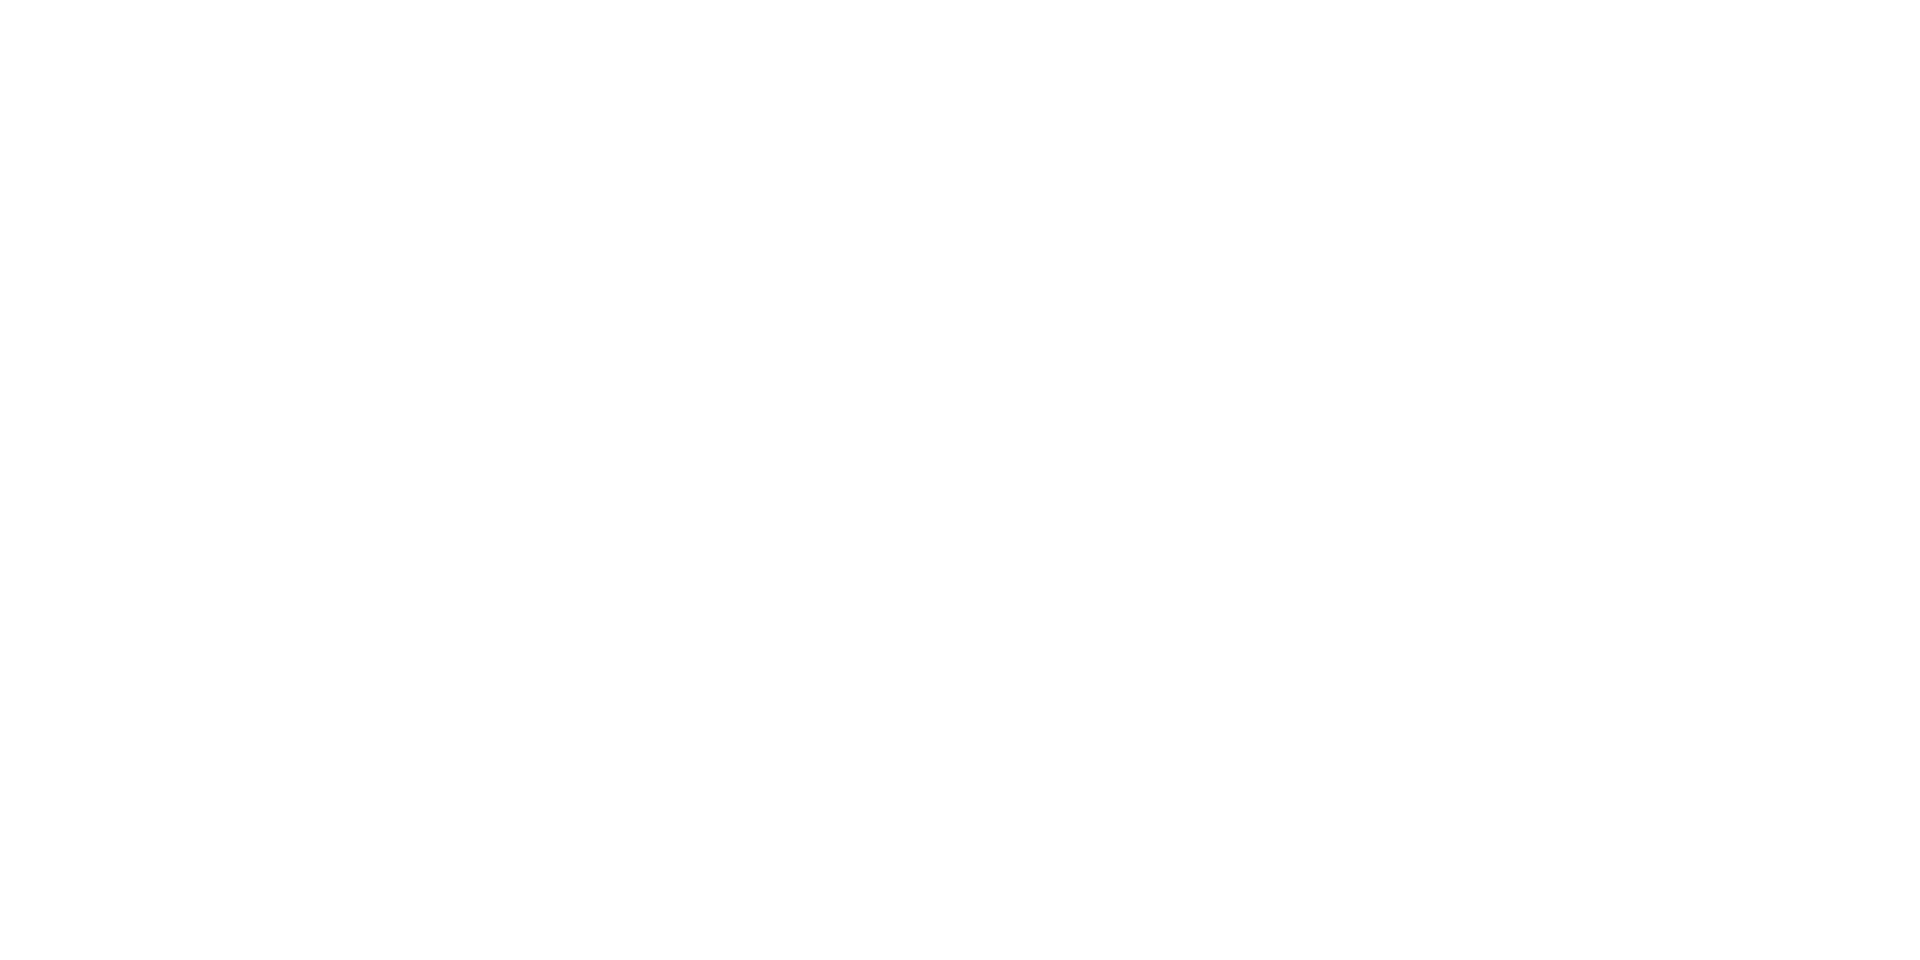

<IPython.core.display.Javascript object>


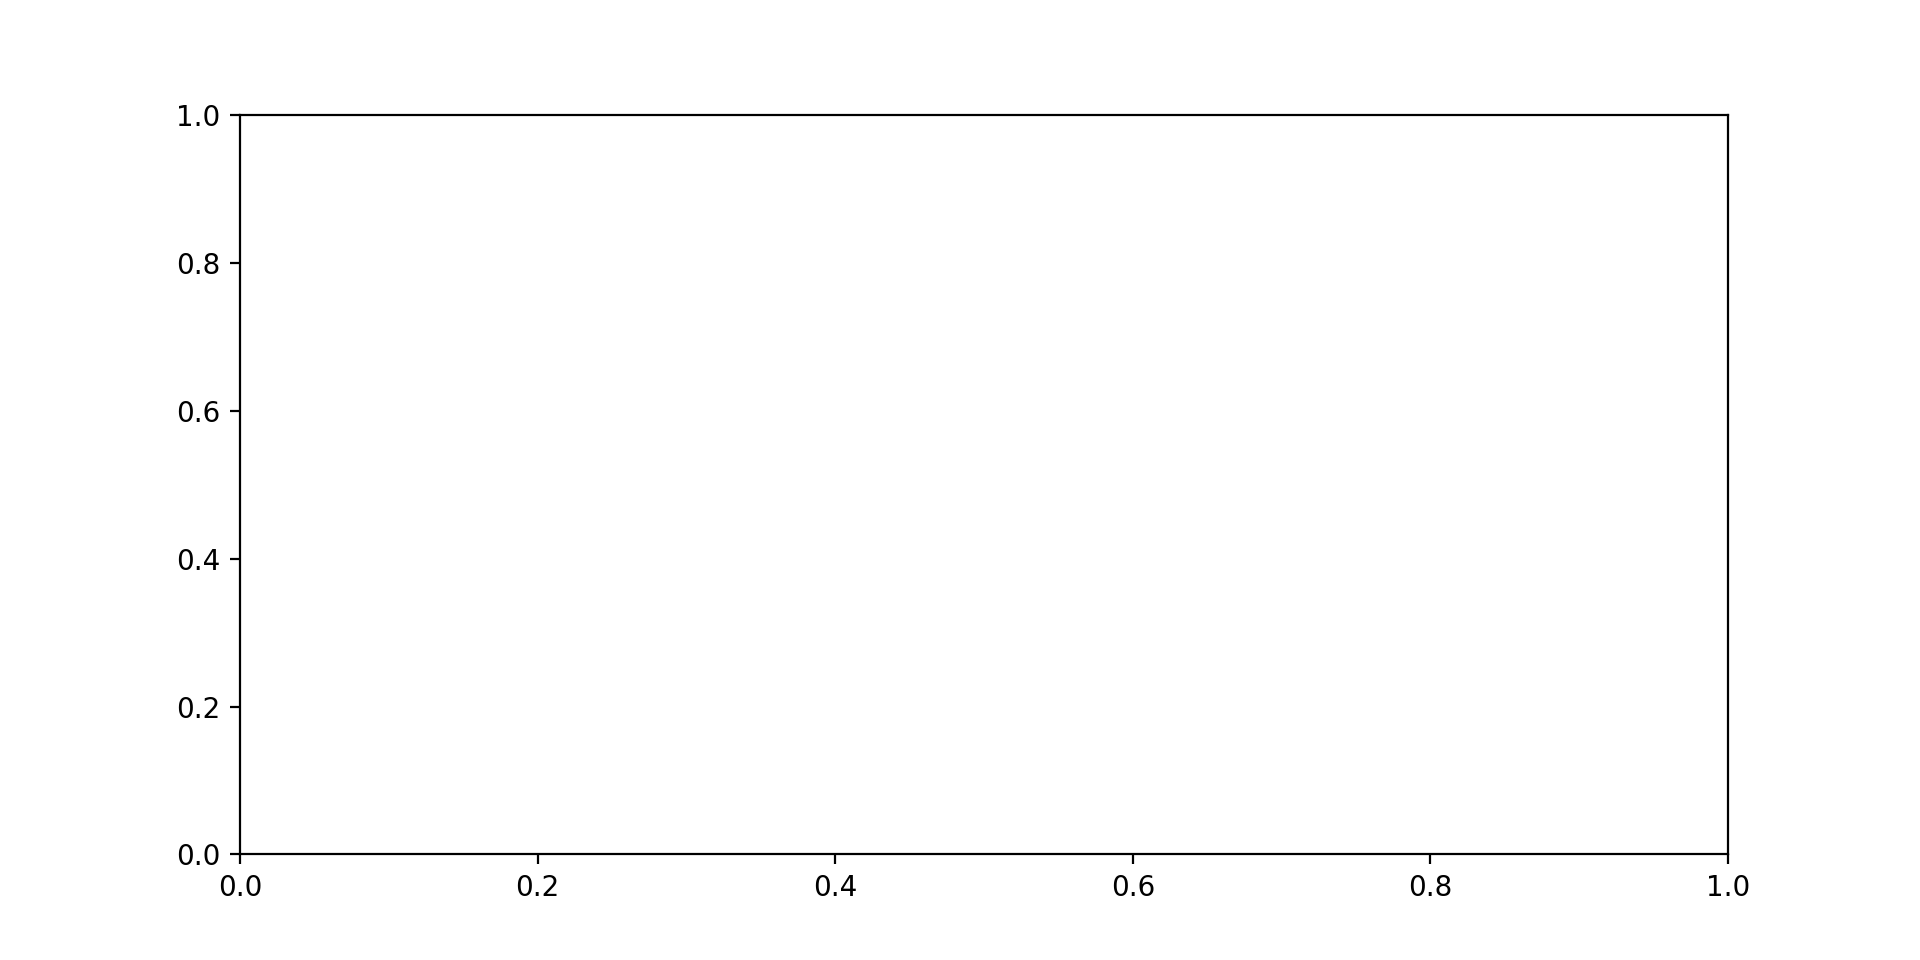

Lander Env
Landing_icgen:
    nominal_g                   :  -3.7114
    downrange                   :  (0, 2000, -70, -10)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
    adjust_apf_v0               :  True
Policy with vectorized sample
	xn_init: layer  Linear(in_features=5, out_features=50, bias=True)
	xn_init: layer  GRUCell(50, 38)
	xn_init: layer  Linear(in_features=38, out_features=30, bias=True)
	xn_init: layer  Linear(in_features=30, out_features=3, bias=True)
[[-1.]
 [ 0.]
 [ 1.]]
	Test Mode:          False
	Clip Param:         0.1
	Shuffle :           False
	Max Grad Norm:      30
	Recurrent Steps:    1
	Rollout Limit:      1
Value Funtion
	xn_init: layer  Linear(in_features=5, out_features=50, bias=True)
	xn_init: layer  GRUCell(50, 15)
	xn_init: layer  Linear(in_features=15, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
	Clip Range:         0.5
	Shuffle :  

In [7]:
from env_killengine_test import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen2 import Landing_icgen
import rl_utils

from arch_policy_vf import Arch


from policy import Policy
from value_function import Value_function


import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model()
lander_model = Lander_model(apf_tau1=20,apf_tau2=100,apf_vf1=-2,apf_vf2=-1,apf_v0=70,apf_atarg=15.)
lander_model.get_state_agent = lander_model.get_state_agent5
lander_model.max_thrust = 24000
lander_model.min_thrust = 4000
obs_dim = 5
act_dim = 3
recurrent_steps = 1

reward_object = Reward()

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          kill_lateral_scale=2.0,
          kill_vertical_scale=1.5,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=100.0,print_every=10,
          p_kill=0.5)

env.ic_gen = Landing_icgen(mass_uncertainty=0.05, 
                           g_uncertainty=(0.05,0.05),
                           adjust_apf_v0=True,
                          downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70))
env.ic_gen.show()

arch = Arch()

policy = Policy(policy_nets.GRU(obs_dim, act_dim, recurrent_steps=recurrent_steps), shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30,
                init_func=rl_utils.xn_init)
value_function = Value_function(valfunc_nets.GRU(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=False, batch_size=9999999, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
load_params=True
fname = "recurrent_policy-rkill-1step"
if load_params:
    policy.load_params(fname)
    value_function.load_params(fname)
else:    
    agent.train(30000)


# Test Policy 

In [9]:
policy.test_mode=True
env.kill_lateral_scale=2.5
env.kill_vertical_scale=1.5
env.test_policy_batch(agent,10000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10150.88 |3457.48 |4000.00 |24000.00 |    25
glideslope | 4.720 |10.294 | 0.715 |682.827 |    92
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.915 |   0.453 |   0.102 |   4.179
norm_rf  |     0.8 |     0.2 |     0.4 |     1.2
position |     0.6     0.5    -0.0 |     0.2     0.2     0.0 |     0.0    -0.2    -0.1 |     1.1     0.9    -0.0
velocity |   0.051   0.070  -0.909 |   0.049   0.034   0.453 |  -0.112  -0.055  -4.171 |   0.342   0.162  -0.098
fuel     |297.82 | 18.58 |258.25 |356.01
glideslope | 14.50 |  3.65 |  8.25 | 27.10
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |10096.99 |3399.39 |4000.00 |24000.00 |   190
glideslope | 4.237 | 8.514 | 0.715 |682.827 |    92
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.968 |   0.503 |   0.102 |   4.179
norm_rf  |     0.8 |     0.2 |     0.4 |     1.3
position |    

i :  1400
Cumulative Stats (mean,std,max,argmax)
thrust   |10119.84 |3470.28 |4000.00 |24000.00 |   697
glideslope | 4.141 | 9.150 | 0.532 |1667.951 |   360
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.957 |   0.500 |   0.043 |   4.590
norm_rf  |     0.9 |     0.2 |     0.3 |     1.5
position |     0.6     0.5    -0.0 |     0.2     0.2     0.0 |    -0.3    -0.4    -0.2 |     1.2     1.2    -0.0
velocity |   0.058   0.070  -0.950 |   0.043   0.036   0.501 |  -0.151  -0.164  -4.582 |   0.344   0.332  -0.012
fuel     |298.13 | 16.95 |258.25 |375.75
glideslope | 14.21 |  3.87 |  7.13 | 34.44
i :  1500
Cumulative Stats (mean,std,max,argmax)
thrust   |10123.06 |3470.14 |4000.00 |24000.00 |   697
glideslope | 4.129 | 9.049 | 0.532 |1667.951 |   360
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.958 |   0.503 |   0.043 |   4.590
norm_rf  |     0.9 |     0.2 |     0.3 |     1.5
position |

i :  2700
Cumulative Stats (mean,std,max,argmax)
thrust   |10134.30 |3460.91 |4000.00 |24000.00 |  1723
glideslope | 4.072 | 8.802 | 0.085 |1773.768 |  2098
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.960 |   0.496 |   0.043 |   4.754
norm_rf  |     0.9 |     0.2 |     0.3 |     1.7
position |     0.6     0.5    -0.0 |     0.2     0.2     0.0 |    -0.3    -0.5    -0.2 |     1.4     1.3    -0.0
velocity |   0.058   0.069  -0.954 |   0.043   0.037   0.497 |  -0.151  -0.164  -4.747 |   0.404   0.332  -0.012
fuel     |298.46 | 16.98 |258.25 |375.75
glideslope | 14.36 |  3.96 |  6.71 | 39.22
i :  2800
Cumulative Stats (mean,std,max,argmax)
thrust   |10133.86 |3455.85 |4000.00 |24000.00 |  1723
glideslope | 4.066 | 8.752 | 0.085 |1773.768 |  2098
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.960 |   0.491 |   0.043 |   4.754
norm_rf  |     0.9 |     0.2 |     0.3 |     1.7
position |

i :  4000
Cumulative Stats (mean,std,max,argmax)
thrust   |10135.91 |3467.87 |4000.00 |24000.00 |  3643
glideslope | 4.079 | 8.741 | 0.085 |1773.768 |  2098
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.954 |   0.473 |   0.043 |   4.754
norm_rf  |     0.9 |     0.2 |     0.3 |     1.7
position |     0.6     0.5    -0.0 |     0.2     0.2     0.0 |    -0.3    -0.5    -0.2 |     1.4     1.3    -0.0
velocity |   0.058   0.069  -0.947 |   0.043   0.036   0.474 |  -0.151  -0.242  -4.747 |   0.579   0.332  -0.003
fuel     |298.57 | 16.89 |258.25 |375.75
glideslope | 14.29 |  3.84 |  6.04 | 39.22
i :  4100
Cumulative Stats (mean,std,max,argmax)
thrust   |10134.62 |3467.97 |4000.00 |24000.00 |  3643
glideslope | 4.089 | 8.896 | 0.085 |1773.768 |  2098
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.954 |   0.473 |   0.043 |   4.754
norm_rf  |     0.9 |     0.2 |     0.3 |     1.7
position |

i :  5300
Cumulative Stats (mean,std,max,argmax)
thrust   |10126.79 |3446.58 |4000.00 |24000.00 |  3643
glideslope | 4.087 | 9.321 | 0.085 |3364.340 |  5279
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.953 |   0.463 |   0.043 |   4.754
norm_rf  |     0.9 |     0.2 |     0.3 |     1.7
position |     0.6     0.5    -0.0 |     0.2     0.2     0.0 |    -0.3    -0.5    -0.2 |     1.4     1.3    -0.0
velocity |   0.058   0.069  -0.946 |   0.044   0.037   0.465 |  -0.151  -0.242  -4.747 |   0.579   0.332   0.060
fuel     |298.34 | 16.85 |255.58 |375.75
glideslope | 14.28 |  3.84 |  6.04 | 39.22
i :  5400
Cumulative Stats (mean,std,max,argmax)
thrust   |10126.25 |3445.55 |4000.00 |24000.00 |  3643
glideslope | 4.099 | 9.382 | 0.085 |3364.340 |  5279
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.951 |   0.462 |   0.043 |   4.754
norm_rf  |     0.9 |     0.2 |     0.3 |     1.7
position |

i :  6600
Cumulative Stats (mean,std,max,argmax)
thrust   |10121.40 |3438.93 |4000.00 |24000.00 |  3643
glideslope | 4.097 | 9.172 | 0.085 |3364.340 |  5279
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.955 |   0.663 |   0.043 |  40.066
norm_rf  |     0.9 |     4.8 |     0.3 |   390.6
position |     0.6     0.5    -0.0 |     4.7     1.1     0.0 |  -381.5   -83.7    -0.3 |     1.4     1.3    -0.0
velocity |   0.062   0.071  -0.946 |   0.328   0.135   0.567 |  -0.185  -0.242 -28.135 |  26.463  10.651   0.091
fuel     |298.24 | 16.80 |222.48 |375.75
glideslope | 14.26 |  3.86 |  0.99 | 41.64
i :  6700
Cumulative Stats (mean,std,max,argmax)
thrust   |10121.92 |3440.07 |4000.00 |24000.00 |  3643
glideslope | 4.096 | 9.147 | 0.085 |3364.340 |  5279
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.956 |   0.662 |   0.043 |  40.066
norm_rf  |     0.9 |     4.8 |     0.3 |   390.6
position |

i :  7900
Cumulative Stats (mean,std,max,argmax)
thrust   |10120.07 |3440.91 |4000.00 |24000.00 |  7351
glideslope | 4.095 | 9.124 | 0.085 |3364.340 |  5279
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.963 |   0.795 |   0.043 |  42.779
norm_rf  |     1.0 |     7.2 |     0.3 |   511.2
position |     0.5     0.5    -0.0 |     6.9     2.1     0.0 |  -484.4  -163.4    -1.1 |     1.4     1.3    -0.0
velocity |   0.065   0.073  -0.953 |   0.412   0.223   0.649 |  -0.185  -0.242 -30.424 |  26.463  16.527   0.091
fuel     |298.25 | 16.79 |222.48 |375.75
glideslope | 14.26 |  3.88 |  0.99 | 41.64
i :  8000
Cumulative Stats (mean,std,max,argmax)
thrust   |10118.69 |3439.83 |4000.00 |24000.00 |  7351
glideslope | 4.098 | 9.142 | 0.085 |3364.340 |  5279
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.962 |   0.791 |   0.043 |  42.779
norm_rf  |     1.0 |     7.2 |     0.3 |   511.2
position |

i :  9200
Cumulative Stats (mean,std,max,argmax)
thrust   |10120.52 |3441.51 |4000.00 |24000.00 |  7351
glideslope | 4.091 | 9.380 | 0.083 |3725.761 |  8281
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.964 |   0.759 |   0.043 |  42.779
norm_rf  |     1.0 |     6.7 |     0.3 |   511.2
position |     0.5     0.5    -0.0 |     6.4     1.9     0.0 |  -484.4  -163.4    -1.1 |     1.4     1.3    -0.0
velocity |   0.063   0.073  -0.955 |   0.382   0.207   0.629 |  -0.185  -0.242 -30.424 |  26.463  16.527   0.091
fuel     |298.29 | 16.71 |222.48 |375.75
glideslope | 14.29 |  3.89 |  0.99 | 41.64
i :  9300
Cumulative Stats (mean,std,max,argmax)
thrust   |10121.39 |3442.60 |4000.00 |24000.00 |  7351
glideslope | 4.091 | 9.358 | 0.083 |3725.761 |  8281
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.963 |   0.756 |   0.043 |  42.779
norm_rf  |     1.0 |     6.7 |     0.3 |   511.2
position |